# Treeple tutorial for calculating p-value with multiview data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sktree.datasets import make_trunk_classification
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sktree.tree import MultiViewDecisionTreeClassifier
from treeple_tutorial_toolbox import Calculate_MI

## Independence Testing

Given samples from `X`, `Z`, and `Y`, the independent hypothesis and its alternative are stated as:

$$H_0 : F_{X,Y|Z} = F_{X|Z} F_{Y|Z}$$
$$H_A : F_{X,Y|Z} \neq F_{X|Z} F_{Y|Z}$$

By computing the p-value using `treeple`, we can test if $H_0$ would be rejected, which confirms the joint distribution between `X|Z` and `Y|Z`. The p-vlaue is generated by comparing the observed statistic difference with permuted differences, using conditional mutual information as an example.

## CMI

Conditional mutual information (*CMI*) measures the dependence of *Y* on *X* conditioned on *Z*. It can be calculated by the difference between the joint MI (`I([X, Z]; Y)`) and the MI on Z (`I(Y; Z)`):

$$I(X; Y | Z) = I([X, Z]; Y) - I(Y; Z)$$

With a multiview binary class simulation as an example, this tutorial will show how to use `treeple` to calculate the statistic and test the hypothesis with multiview data.

## Create a simulation with two gaussians

In [2]:
# create a binary class simulation with two gaussians
# 500 samples for each class, class zero is standard
# gaussian, and class one has a mean at one for Z
Z, y = make_trunk_classification(
    n_samples=1000,
    n_dim=1,
    mu_0=0,
    mu_1=1,
    n_informative=1,
    seed=1,
)


X, y = make_trunk_classification(
    n_samples=1000,
    n_dim=1,
    mu_0=0,
    mu_1=2,
    n_informative=1,
    seed=1,
)

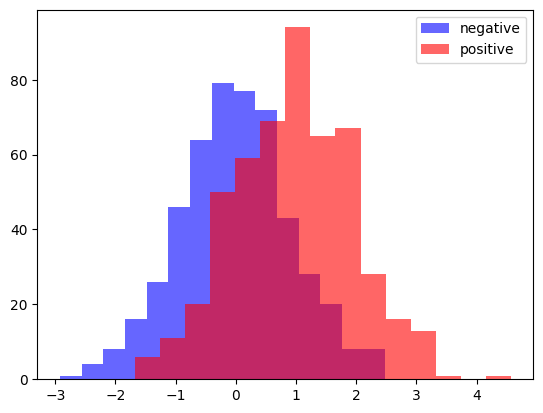

In [3]:
# scatter plot the samples for Z
plt.hist(Z[500:], bins=15, alpha=0.6, color="blue", label="negative")
plt.hist(Z[:500], bins=15, alpha=0.6, color="red", label="positive")
plt.legend()
plt.show()

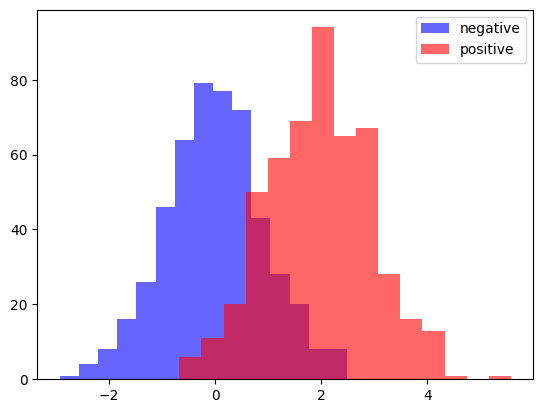

In [4]:
# scatter plot the samples for X
plt.hist(X[500:], bins=15, alpha=0.6, color="blue", label="negative")
plt.hist(X[:500], bins=15, alpha=0.6, color="red", label="positive")
plt.legend()
plt.show()

## Generate observed posteriors with X and Z

In [5]:
# initialize the forest with 100 trees
est = HonestForestClassifier(
    n_estimators=100,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    tree_estimator=MultiViewDecisionTreeClassifier(),
    random_state=1,
)

# fit the model and obtain the tree posteriors
_, observe_proba = build_hyppo_oob_forest(est, np.hstack((X, Z)), y)

# generate forest posteriors for the two classes
observe_proba = np.nanmean(observe_proba, axis=0)

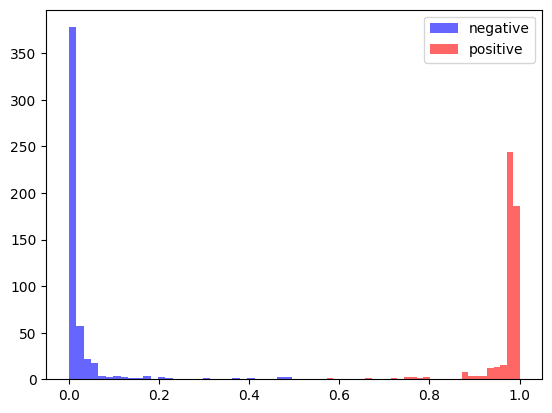

In [6]:
# scatter plot the posterior probabilities for class one
plt.hist(observe_proba[:500][:, 1], bins=30, alpha=0.6, color="blue", label="negative")
plt.hist(observe_proba[500:][:, 1], bins=30, alpha=0.6, color="red", label="positive")
plt.legend()
plt.show()

## Generate observed posteriors with Z only

In [7]:
# initialize the forest with 100 trees
est = HonestForestClassifier(
    n_estimators=100,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    random_state=1,
)

# fit the model and obtain the tree posteriors
_, single_proba = build_hyppo_oob_forest(est, Z, y)

# generate forest posteriors for the two classes
single_proba = np.nanmean(single_proba, axis=0)

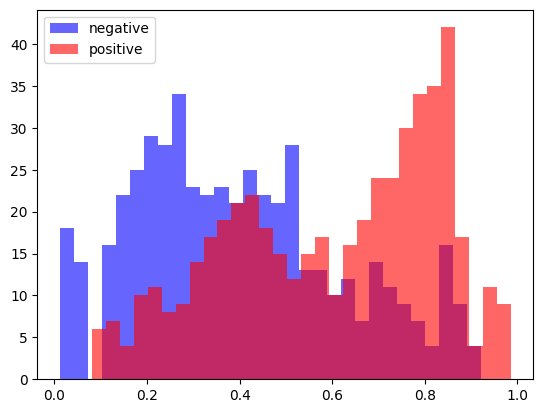

In [8]:
# scatter plot the posterior probabilities for class one
plt.hist(single_proba[:500][:, 1], bins=30, alpha=0.6, color="blue", label="negative")
plt.hist(single_proba[500:][:, 1], bins=30, alpha=0.6, color="red", label="positive")
plt.legend()
plt.show()

## Generate null posteriors with Z and permuted X

In [9]:
# shuffle the labels
X_null = np.copy(X)
np.random.shuffle(X_null)

# initialize another forest with 100 trees
est_null = HonestForestClassifier(
    n_estimators=100,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    tree_estimator=MultiViewDecisionTreeClassifier(),
    random_state=1,
)

# fit the model and obtain the tree posteriors
_, null_proba = build_hyppo_oob_forest(est, np.hstack((X_null, Z)), y)

# generate forest posteriors for the two classes
null_proba = np.nanmean(null_proba, axis=0)

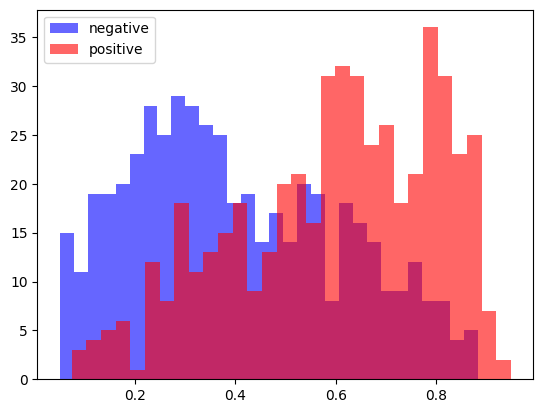

In [10]:
# scatter plot the posterior probabilities for class one
plt.hist(null_proba[:500][:, 1], bins=30, alpha=0.6, color="blue", label="negative")
plt.hist(null_proba[500:][:, 1], bins=30, alpha=0.6, color="red", label="positive")
plt.legend()
plt.show()

## Find the observed statistic difference

In [11]:
joint_mi = Calculate_MI(y, observe_proba)
mi = Calculate_MI(y, single_proba)
cmi = joint_mi - mi

joint_mi_null = Calculate_MI(y, null_proba)
cmi_null = joint_mi_null - mi

observed_diff = cmi - cmi_null
print("Observed statistic difference =", round(observed_diff, 2))

Observed statistic difference = 0.49


## Permute the tree posteriors

In [12]:
PERMUTE = 10000
mix_diff = []

# Collect all the tree posteriors
proba = np.vstack((observe_proba, null_proba))
for i in range(PERMUTE):

    # permute the posteriors
    np.random.shuffle(proba)

    # calculate the statistic for
    # the two mixed forest posteriors
    mi_mix_one = Calculate_MI(y, proba[:100])
    mi_mix_two = Calculate_MI(y, proba[100:])

    # same difference of joint MI and CMI
    mix_diff.append(mi_mix_one - mi_mix_two)

## Calculate the p-value

In [13]:
pvalue = (1 + (mix_diff >= observed_diff).sum()) / (1 + PERMUTE)

print("p-value is:", round(pvalue, 2))
if pvalue < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is not rejected.")

p-value is: 0.0
The null hypothesis is rejected.
